# 誰でも手軽に医用画像処理
## まずはファイルの確認
ChatGPTへの指示
>pythonでの医用画像処理を手伝ってください．“data > case01”フォルダの中に15枚のDICOMファイルがあります．これらを全て読み込んで，5枚ずつ3段で表示してください．

In [2]:
import os
import glob
import PIL
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from IPython.display import display, Image

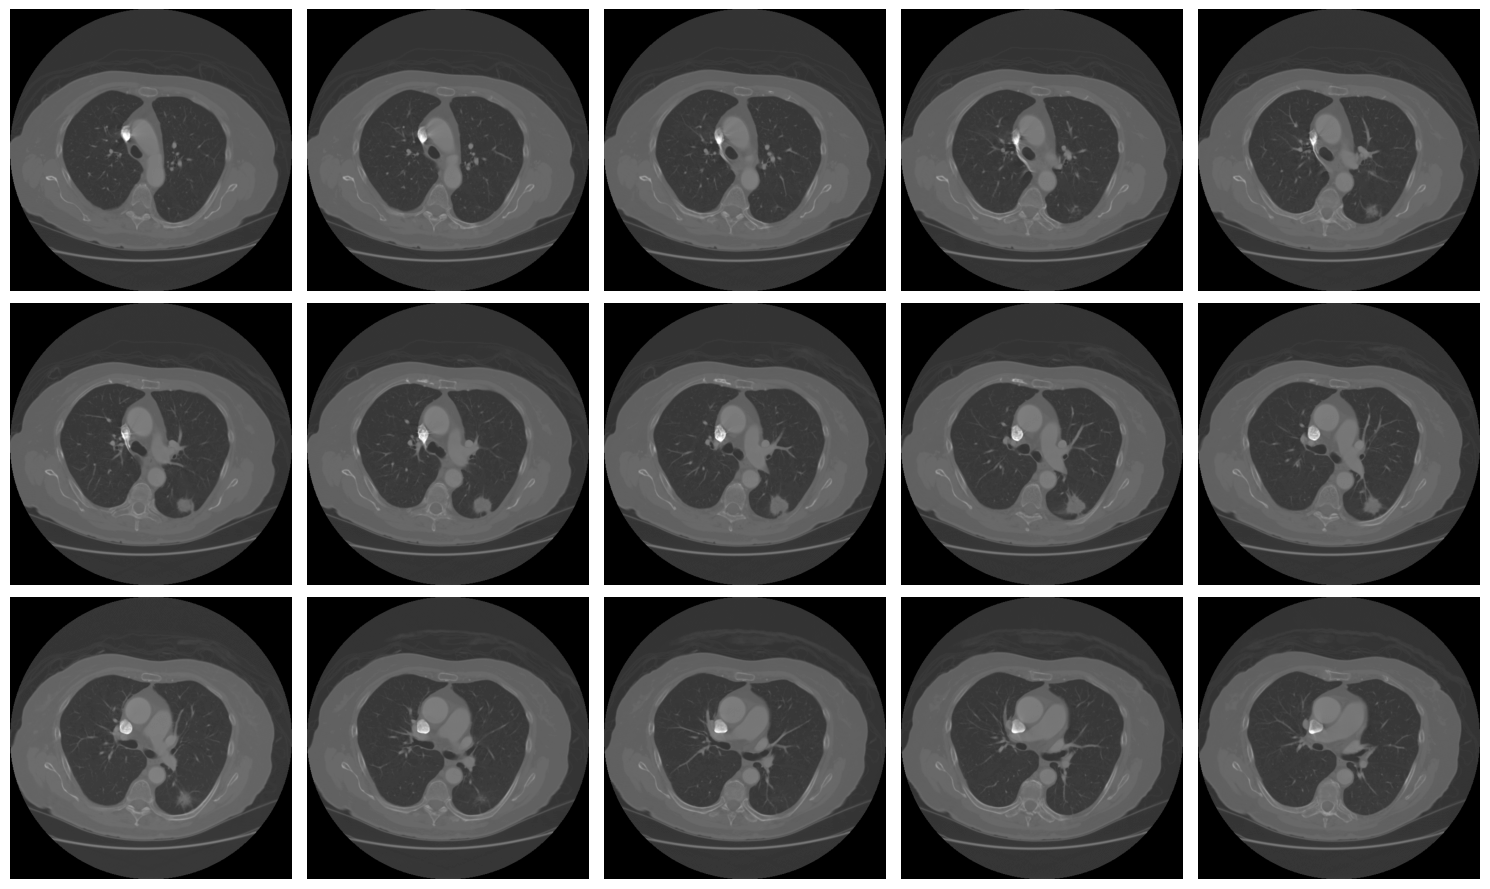

In [3]:
# DICOMファイルがあるフォルダのパス
dicom_folder = 'data/case01'

# フォルダ内のすべてのDICOMファイルをリストアップ
dicom_files = [os.path.join(dicom_folder, f) 
               for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
dicom_files.sort()  

# DICOMファイルを読み込む
images = [sitk.ReadImage(file) for file in dicom_files]

# プロット
images_np = [sitk.GetArrayFromImage(image) for image in images]
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(images_np[i][0], cmap='gray')  
    ax.axis('off')

plt.tight_layout()
plt.show()

## jpegとして保存
ChatGPTへの指示
>表示された画像は胸部CTのようでした．肺野条件になるように適切にwindow levelとwidthを設定した上で，jpeg画像として保存してください．保存先はresultsフォルダとしてください．また，変換後の画像を先ほどと同様に5枚3段で表示してください．

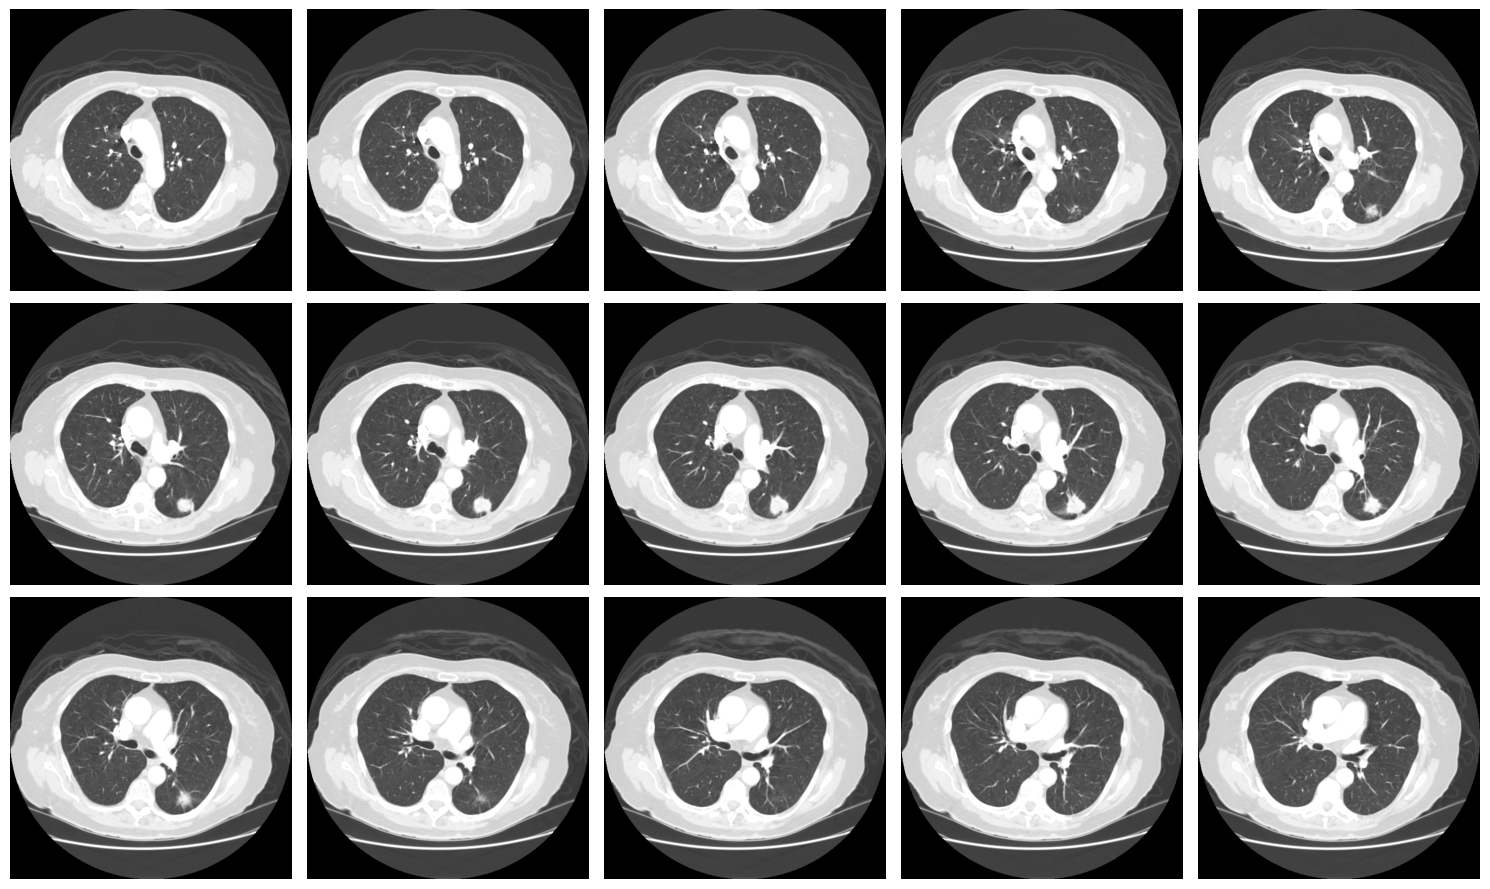

In [9]:
def apply_window_level(image_np, window, level):
    lower = level - window / 2
    upper = level + window / 2
    windowed_image = np.clip(image_np, lower, upper)
    windowed_image = ((windowed_image - lower) / window) * 255.0
    windowed_image = windowed_image.astype(np.uint8)
    return windowed_image

# ウィンドウのパラメータ
window_width = 1500
window_level = -600

# 画像を処理して保存
windowed_images_np = []
for i, image_np in enumerate(images_np):
    # ウィンドウレベルを適用
    windowed_image = apply_window_level(image_np[0], 
                                        window_width, 
                                        window_level)
    windowed_images_np.append(windowed_image)

    # JPEGとして保存するためにPILイメージに変換して保存
    pil_image = PIL.Image.fromarray(windowed_image)
    pil_image.save(f'results/image_{i+1:02}.jpg')

# ウィンドウ化された画像を表示
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(windowed_images_np[i], cmap='gray')  
    ax.axis('off')

plt.tight_layout()
plt.show()

## 動画ファイルの作成
>この15枚のjpegファイルを動画ファイルにしてください．形式はgifでお願いします．フレームレートは4枚/秒にしてください．作成されたファイルはresultsフォルダの中にmovie.gifとして保存してください．また，ipynb上でも表示してください．

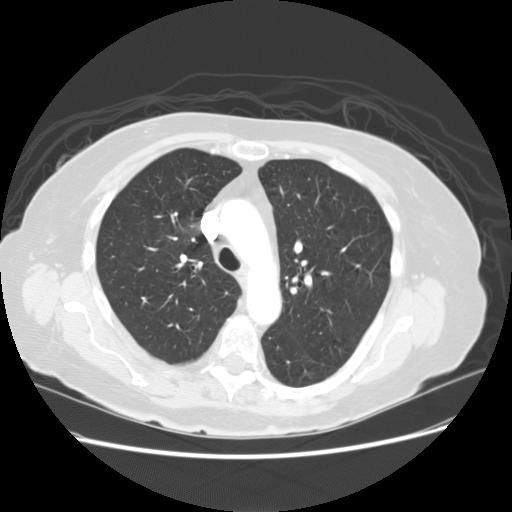

In [18]:
# "resultsフォルダ内のJPEGファイルを取得
jpeg_files = sorted(glob.glob('results/*.jpg'))

# 各JPEG画像を読み込み、GIFに変換
images = [PIL.Image.open(jpeg) for jpeg in jpeg_files]

# GIFファイルを作成し、保存
images[0].save(
    'results/4per1sec.gif', 
    save_all=True, 
    append_images=images[1:], 
    duration=250, 
    loop=0
    )

# GIFを表示
display(Image(filename='results/4per1sec.gif'))

## 高解像度化
ChatGPTへの指示
>今保存した9番目の画像に該当するものを高解像度化したいです．具体的には，300dpiで長辺が10cmになるようにしてください．また，変更の前後で縦横のpixel数がどう変化したかも教えてください．新しいファイルはresultsフォルダの中に，hr_image_09.jpgとして保存してください．

In [19]:
# 高解像度変換のためのパラメータ
dpi = 300  # 1インチあたりのドット数
target_length_cm = 10  # 目標の長さ（センチメートル）
target_length_inches = target_length_cm / 2.54  # センチメートルをインチに変換

# 9番目の画像を読み込む
image_09 = PIL.Image.open('results/image_09.jpg')

# 元の画像の寸法（ピクセル）
original_dimensions = image_09.size

# 新しい寸法を計算
# 長さが300dpiで10cmの場合、ピクセル数 = 300 * (10 / 2.54)
new_length = int(dpi * target_length_inches)
aspect_ratio = original_dimensions[0] / original_dimensions[1]

if original_dimensions[0] > original_dimensions[1]:  # 横長の場合
    new_dimensions = (new_length, int(new_length / aspect_ratio))
else:  # 縦長の場合
    new_dimensions = (int(new_length * aspect_ratio), new_length)

# 画像のリサイズ
image_09_hr = image_09.resize(new_dimensions, PIL.Image.Resampling.LANCZOS)

# 高解像度画像を保存
image_09_hr.save("results/hr_image_09.jpg")

print(f"元の画像サイズ: {original_dimensions[0]} x {original_dimensions[1]} ピクセル, ")
print(f"新しい画像サイズ: {new_dimensions[0]} x {new_dimensions[1]} ピクセル")

元の画像サイズ: 512 x 512 ピクセル, 
新しい画像サイズ: 1181 x 1181 ピクセル
